In [1]:
#Guide for Processing Sessions with Dreadds2 Class
#Imports & Setup
from myphdlib.interface.dreadds2 import Dreadds2Session
from myphdlib.interface.NR1KO import NR1Session
from myphdlib.interface.mlati import MlatiSession
from myphdlib.pipeline.prediction import predictSaccadeDirection
from myphdlib.pipeline.prediction import predictSaccadeEpochs
import matplotlib.pylab as plt
import os
import re
import numpy as np
from myphdlib.general.labjack import loadLabjackData
import nptracer as npt
from scipy import signal, stats
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn.linear_model import LinearRegression, Ridge, PoissonRegressor
#session = Dreadds2Session('filepath')

In [2]:
sessionsMlati = list()
sessionsMlatiList = ['/media/jbhunt/Seagate Portable Drive/2023-07-31/mlati10',
           '/media/jbhunt/Seagate Portable Drive/2023-07-24/mlati9',
             '/media/jbhunt/Seagate Portable Drive/2023-07-25/mlati10',
             '/media/jbhunt/Seagate Portable Drive/2023-07-26/mlati9',
             '/media/jbhunt/Seagate Portable Drive/2023-07-27/mlati10',
             '/media/jbhunt/Seagate Portable Drive/2023-07-28/mlati9',
             '/media/jbhunt/Seagate Portable Drive/2023-07-31/mlati10',
             '/media/jbhunt/Seagate Portable Drive/2023-08-01/mlati10'
                  ]
                  
for session in sessionsMlatiList:
    sessionToAppend = MlatiSession(session)
    sessionsMlati.append(sessionToAppend)

In [12]:
keys = list()
for session in sessionsMlati:
    keys.append(str(session.date))
premotorUnitsZeta = {key:[] for key in keys}
for session in sessionsMlati:
    spikeClustersFile = session.home.joinpath('ephys/sorting/manual/spike_clusters.npy')
    uniqueSpikeClusters = np.unique(np.load(spikeClustersFile))
    zetaNasal = session.load('zeta/saccade/nasal/p')
    zetaTemporal = session.load('zeta/saccade/temporal/p')
    ampCutoff = session.load('metrics/ac')
    presenceRatio = session.load('metrics/pr')
    firingRate = session.load('metrics/fr')
    isiViol = session.load('metrics/rpvr')
    for index, pVal in enumerate(zetaNasal):
        pNasal = pVal
        pTemporal = zetaTemporal[index]
        if pNasal < pTemporal:
            p = pNasal
        elif pTemporal < pNasal:
            p = pTemporal
        if p < 0.05:
            if ampCutoff[index] <= 0.1:
                if presenceRatio[index] >= 0.9:
                    if firingRate[index] >= 0.2:
                        if isiViol[index] <= 0.5:
                            date = str(session.date)
                            unit = uniqueSpikeClusters[index]
                            premotorUnitsZeta[date].append(unit)

In [7]:
keys = list()
for session in sessionsMlati:
    keys.append(str(session.date))
visualUnitsZeta = {key:[] for key in keys}
for session in sessionsMlati:
    spikeClustersFile = session.home.joinpath('ephys/sorting/manual/spike_clusters.npy')
    uniqueSpikeClusters = np.unique(np.load(spikeClustersFile))
    zetaLeft = session.load('zeta/probe/left/p')
    zetaRight = session.load('zeta/probe/right/p')
    ampCutoff = session.load('metrics/ac')
    presenceRatio = session.load('metrics/pr')
    firingRate = session.load('metrics/fr')
    isiViol = session.load('metrics/rpvr')
    for index, pVal in enumerate(zetaLeft):
        pLeft = pVal
        pRight = zetaRight[index]
        if pLeft < pRight:
            p = pLeft
        elif pRight < pLeft:
            p = pRight
        if p < 0.05:
            if ampCutoff[index] <= 0.1:
                if presenceRatio[index] >= 0.9:
                    if firingRate[index] >= 0.2:
                        if isiViol[index] <= 0.5:
                            date = str(session.date)
                            unit = uniqueSpikeClusters[index]
                            visualUnitsZeta[date].append(unit)

In [6]:
premotor = list()
non = list()
for session in sessionsMlati:
    #fig, ax = plt.subplots()
    for unit in session.population:
        spikeTimes = unit.timestamps
        t, fr = unit.peth(np.array(session.saccadeTimestamps[:, 0]), (-0.2, 0.5), 0.01)
        baseline = np.mean(fr[0:10])
        corrected = fr - baseline
        if unit.cluster in premotorUnitsZeta[str(session.date)]:
            premotor.append(corrected)
        else:
            non.append(corrected)
          #  plt.plot(t, corrected, color='magenta', alpha=0.5)
       # else:
           # plt.plot(t, corrected, color='limegreen', alpha=0.25)


/tmp/ipykernel_1567454/1230277852.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L1 = np.array(L)
/tmp/ipykernel_1567454/1230277852.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


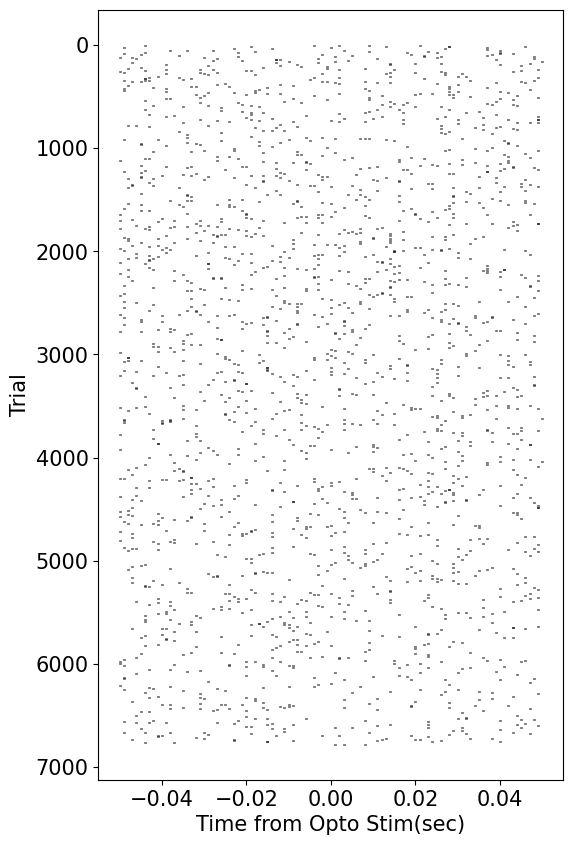

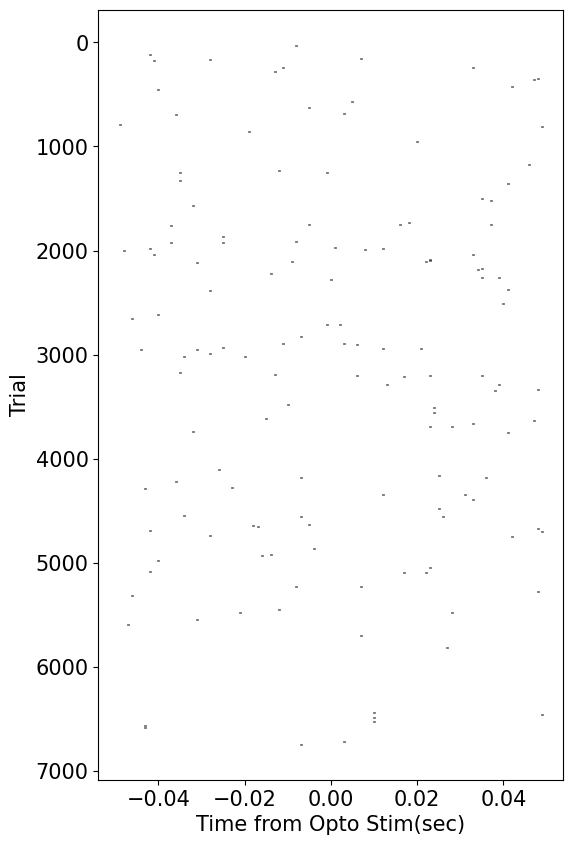

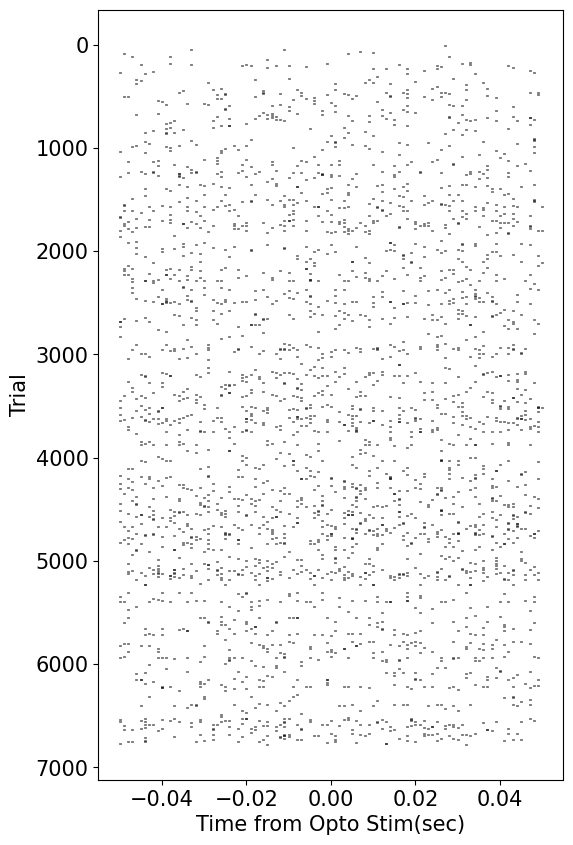

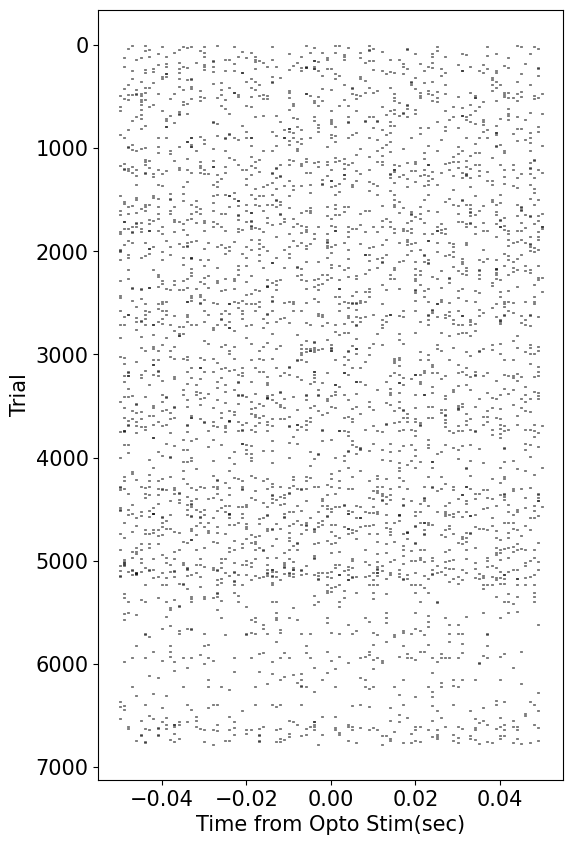

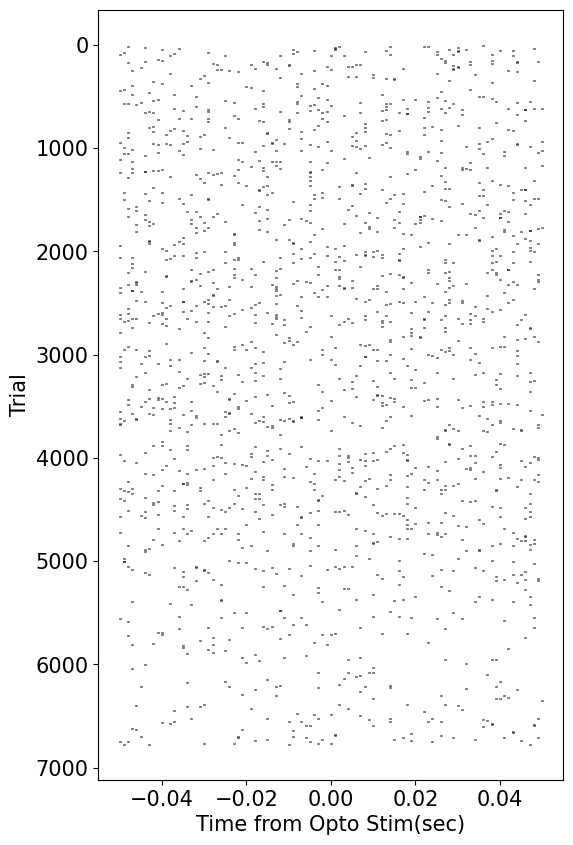

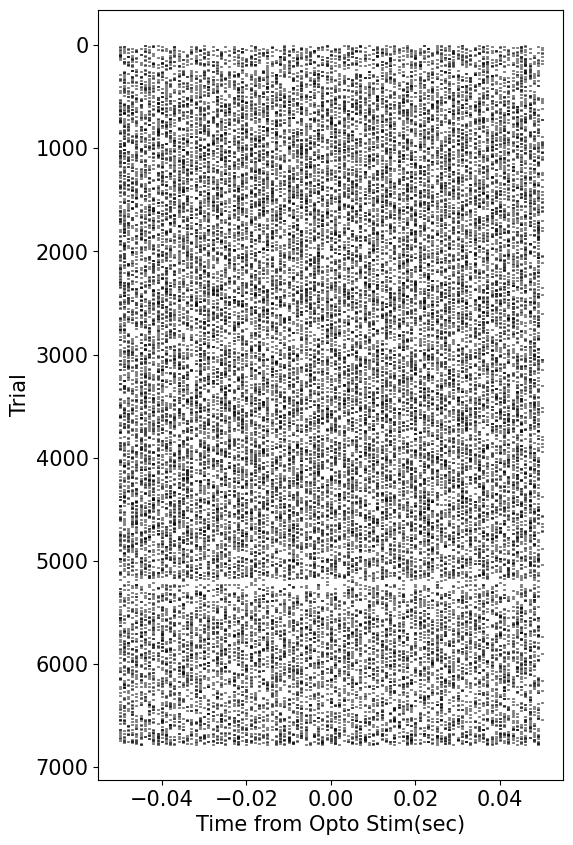

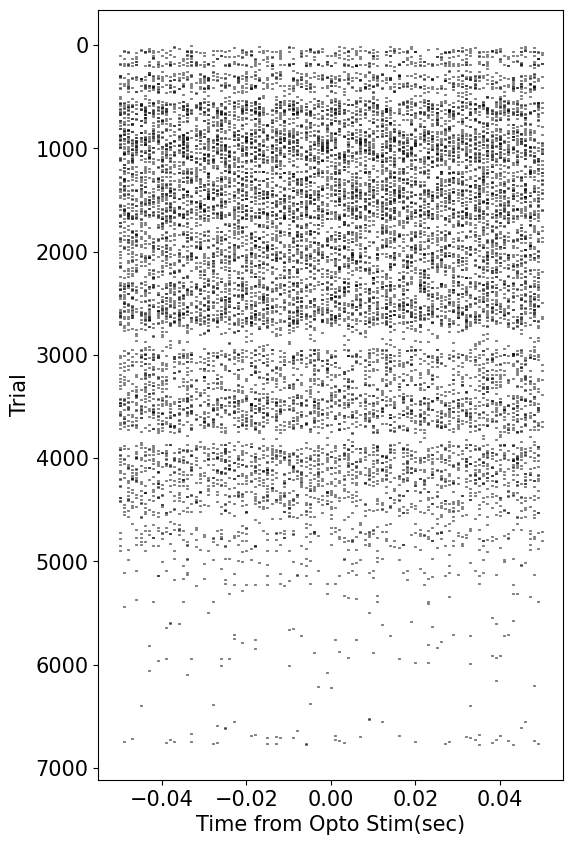

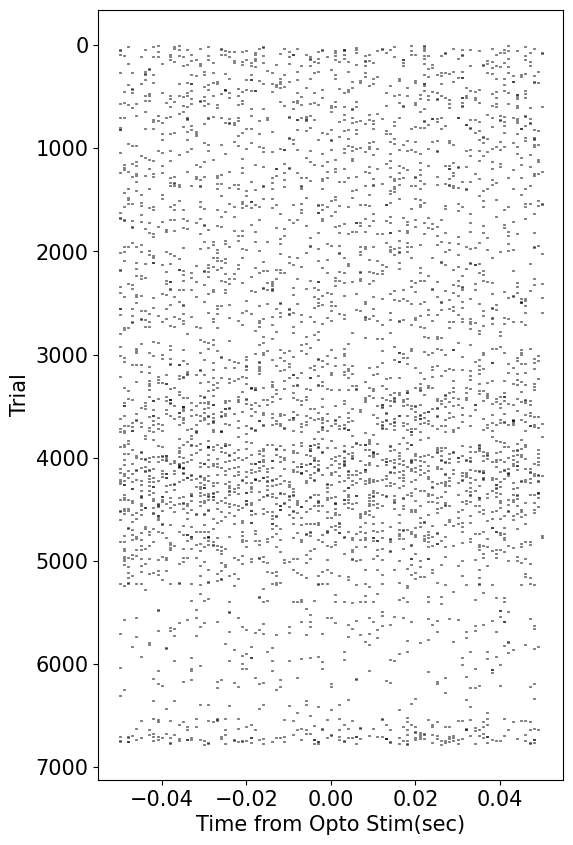

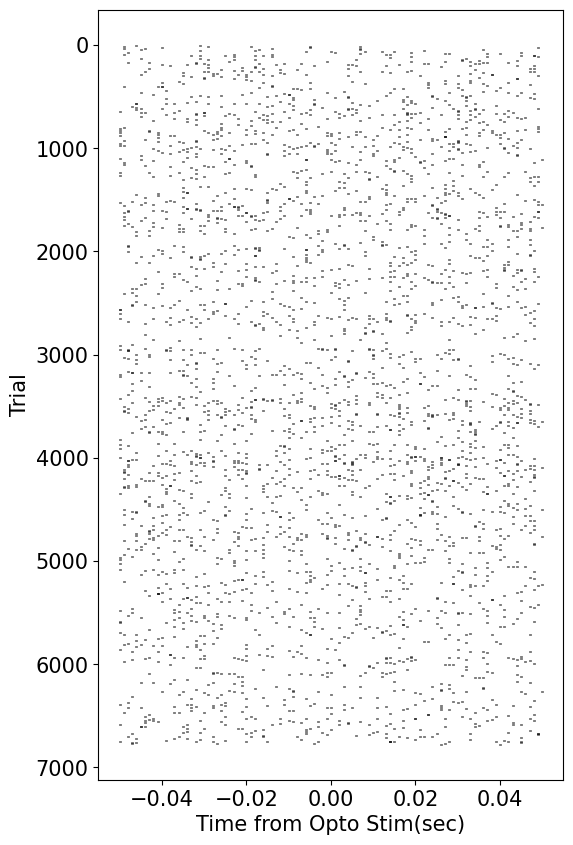

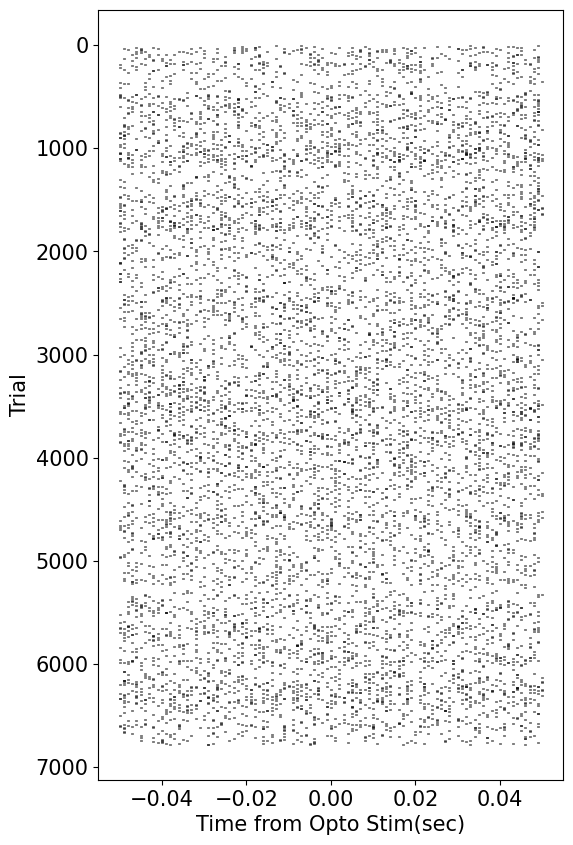

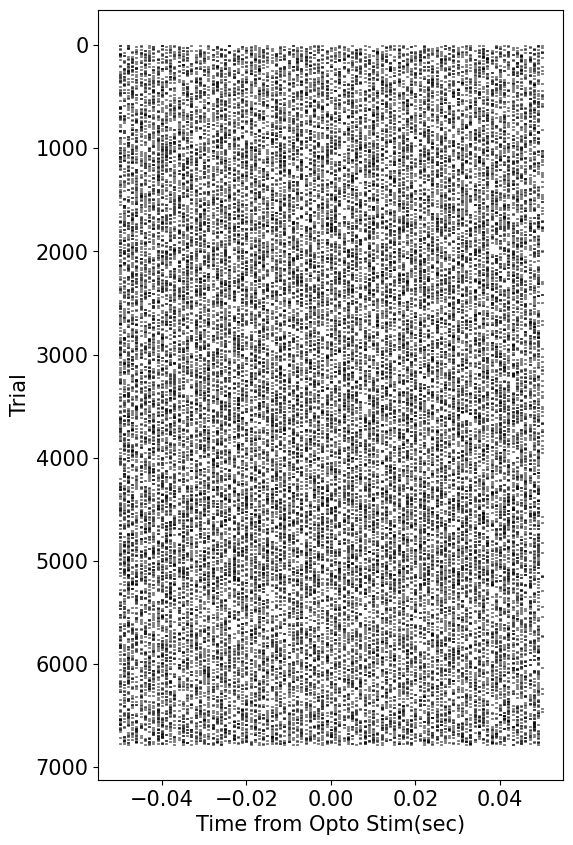

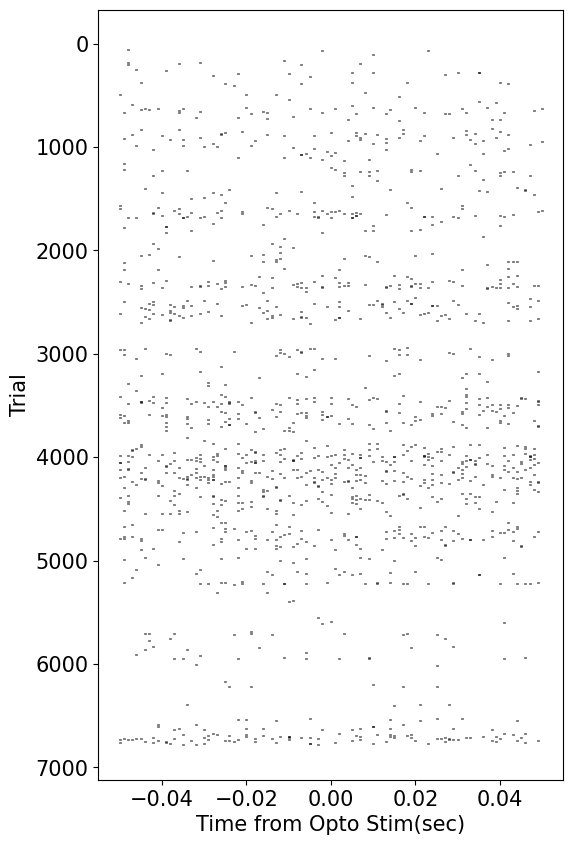

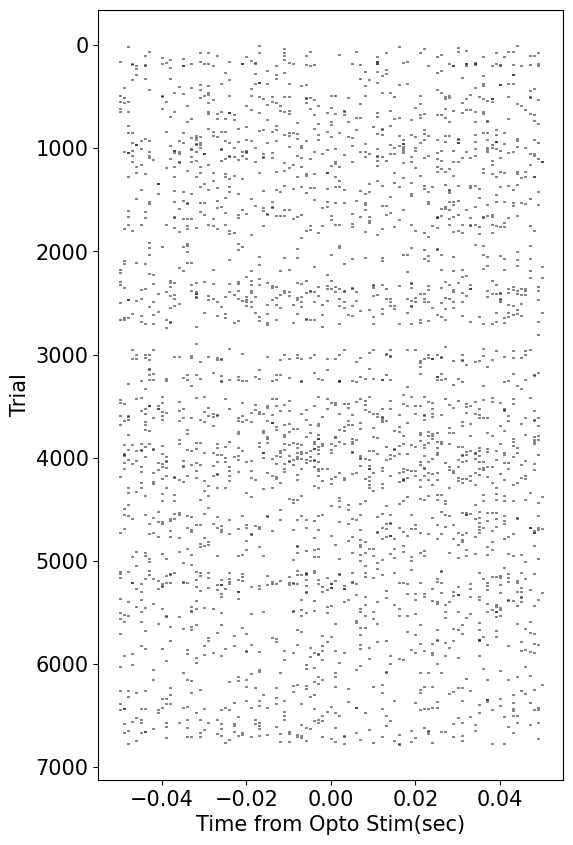

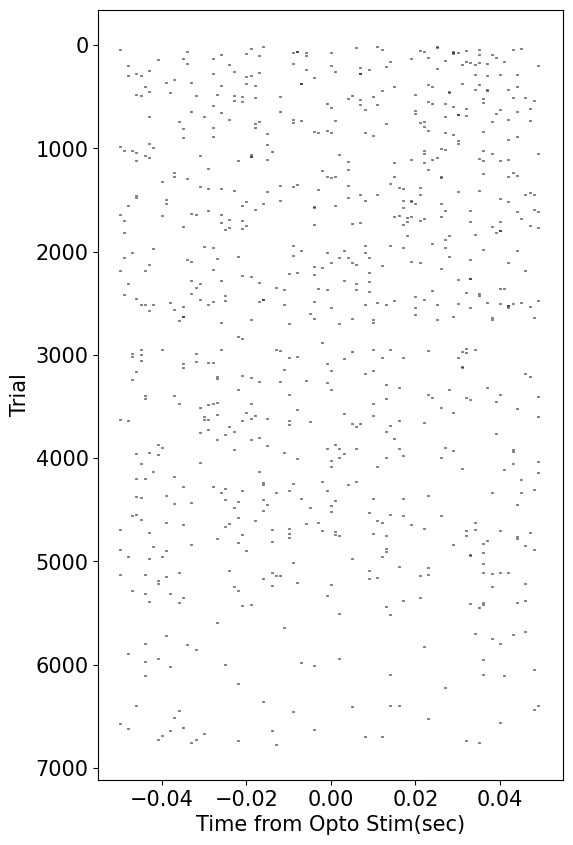

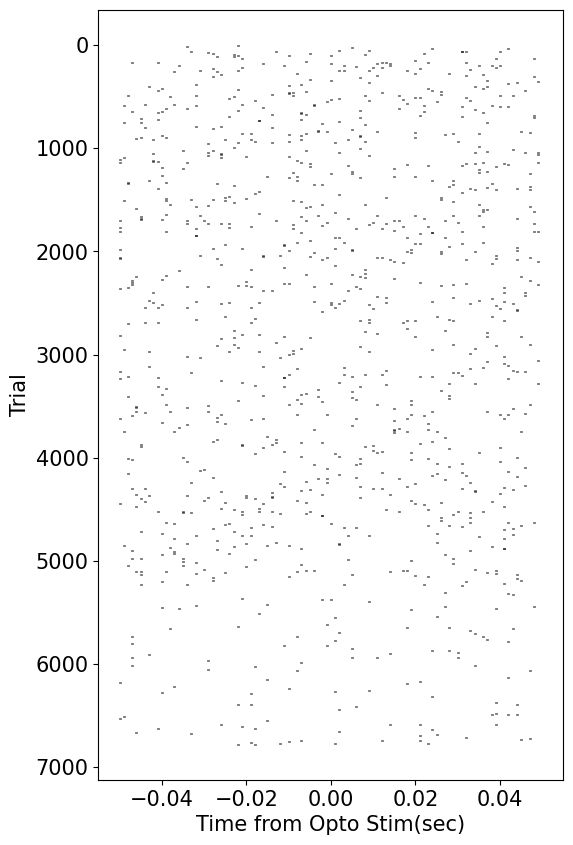

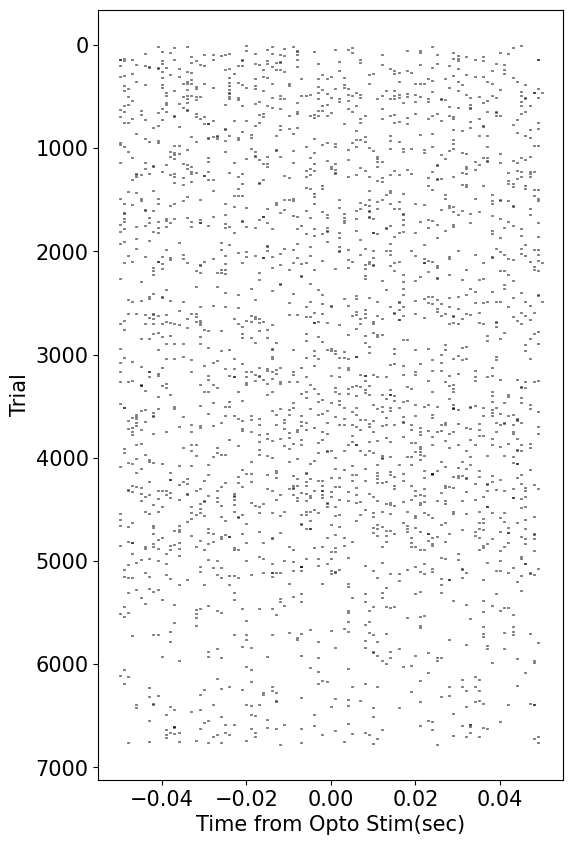

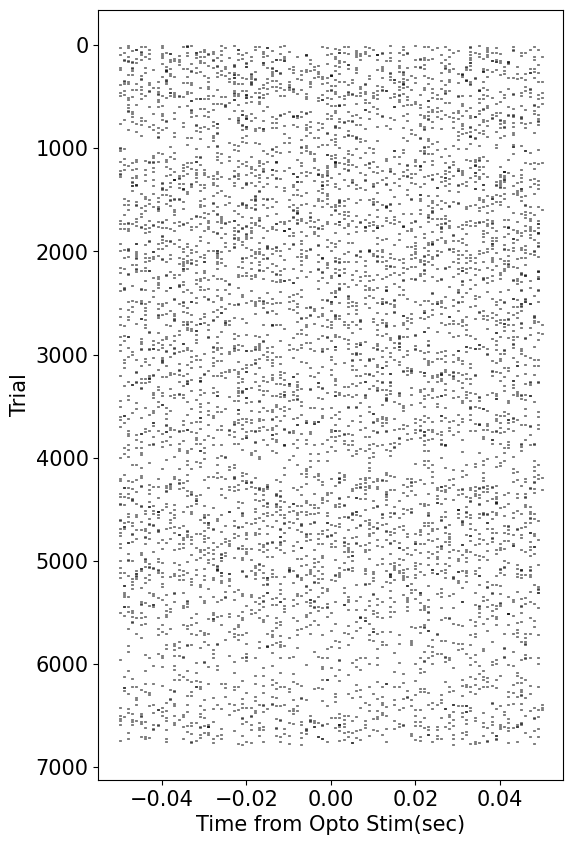

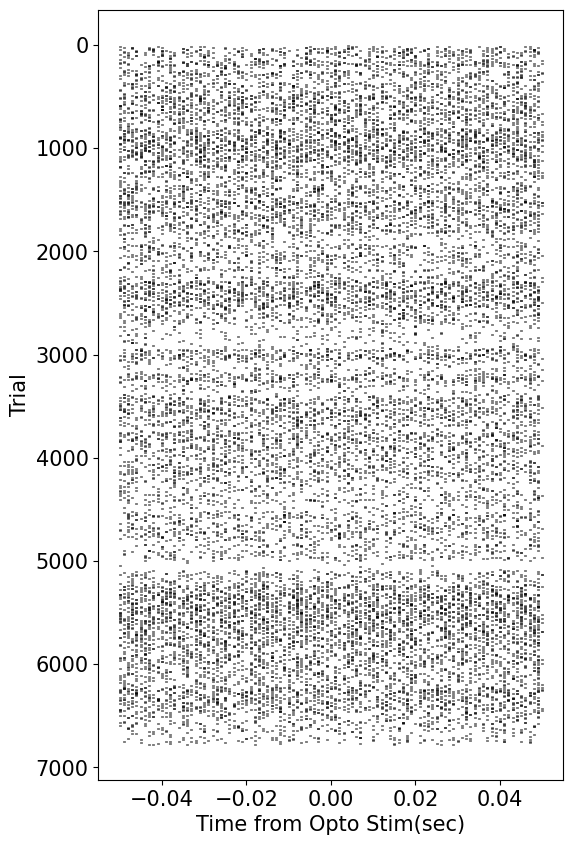

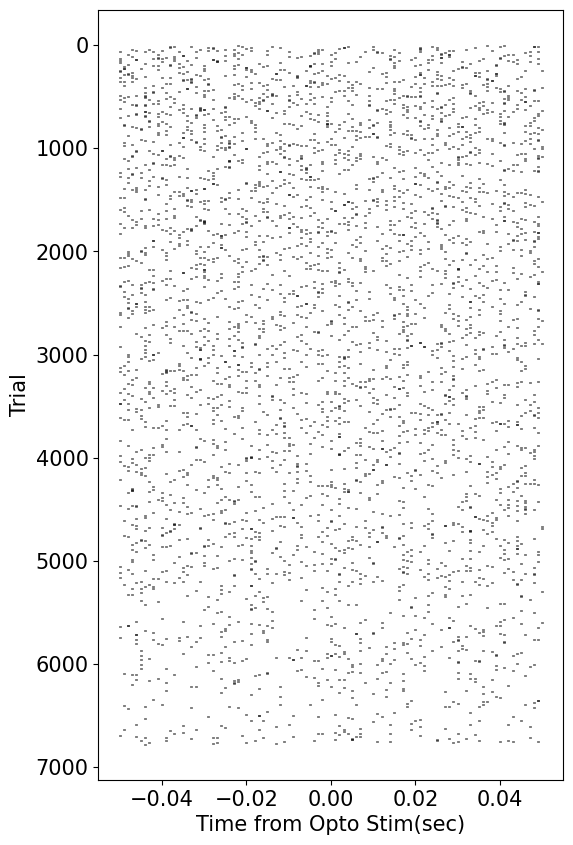

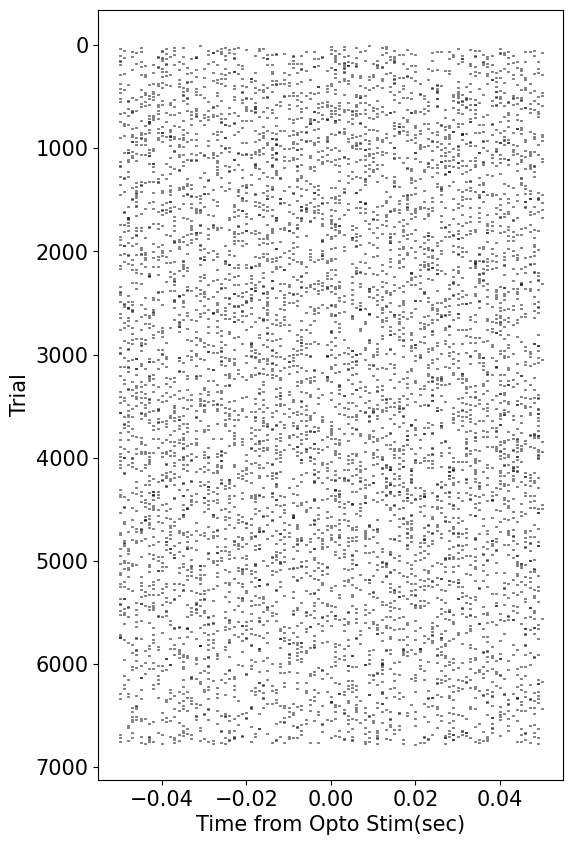

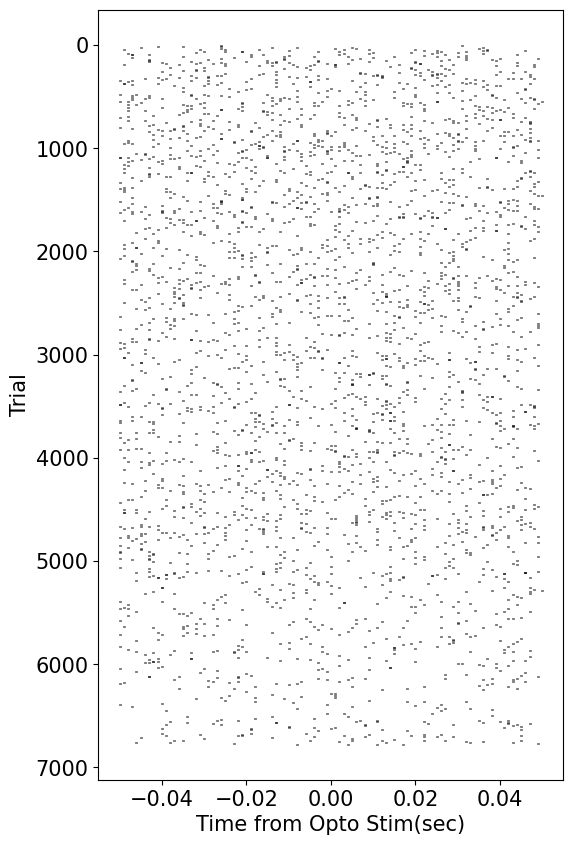

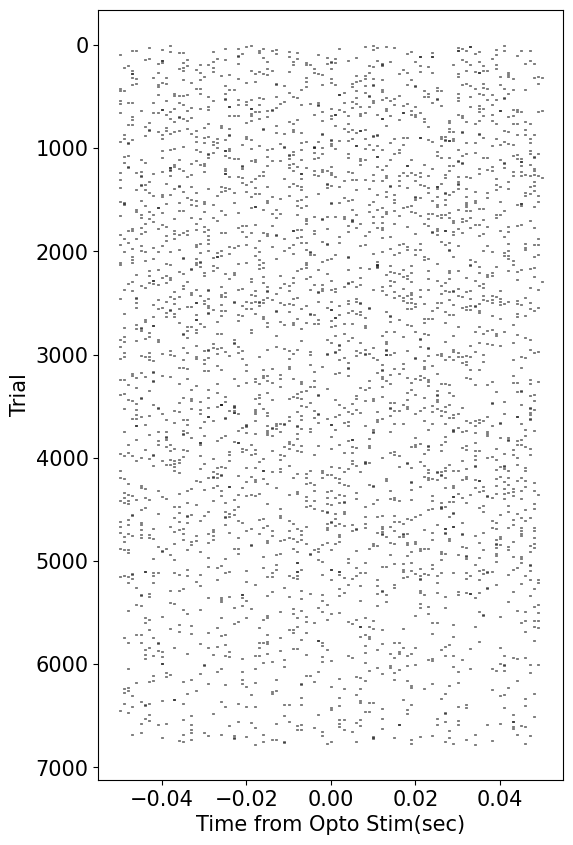

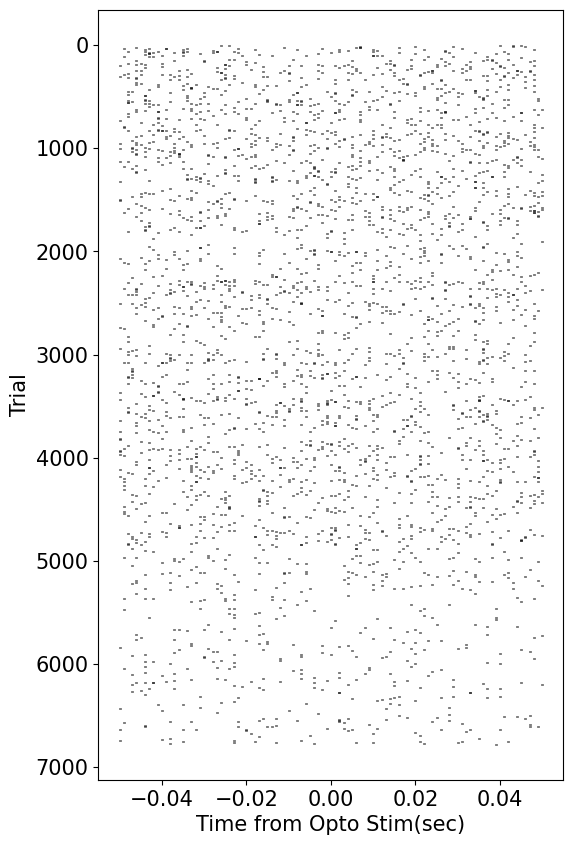

In [21]:
session = sessionsMlati[0]
window = (-0.05, 0.05)
spikeClustersFile = session.home.joinpath('ephys/sorting/manual/spike_clusters.npy')
uniqueSpikeClusters = np.unique(np.load(spikeClustersFile))
for unit in session.population[200:300]:
    index = np.where(uniqueSpikeClusters == unit.cluster)[0].item()
    if unit.cluster in visualUnitsZeta[str(session.date)]:
        L = list()
        #if index in premotorUnits[str(session.date)]:
            #fig, axs = plt.subplots()
        for probe in session.probeTimestamps:
            spikeTimestamps = unit.timestamps
            b1 = probe + window[0]
            b2 = probe + window[1]
            maskB = np.logical_and(spikeTimestamps >= b1, spikeTimestamps < b2)
            b = spikeTimestamps[maskB] - probe
            L.append(b)
        L1 = np.array(L)
        fig, ax = plt.subplots()
        font = {'size' : 15}
        plt.rc('font', **font)
        plt.gca().invert_yaxis()
        for rowIndex, row in enumerate(L1):
            x = row
            y0 = rowIndex - 3
            y1 = rowIndex + 3
            ax.vlines(x, y0, y1, color='k', lw=2)
        ax.set_ylabel('Trial')
        ax.set_xlabel('Time from Opto Stim(sec)')
        fig.set_figheight(10)
        fig.set_figwidth(6)

Text(0, 0.5, 'Average Change in Firing Rate')

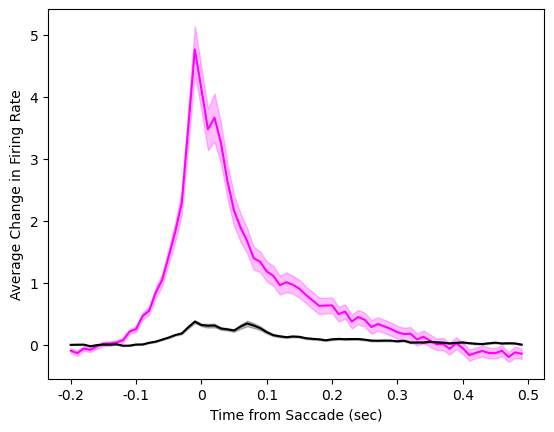

In [8]:
premotorAvg = np.mean(premotor, axis=0)
nonAvg = np.mean(non, axis=0)
premotorStd = stats.sem(premotor, axis=0)
nonStd = stats.sem(non, axis=0)
plt.plot(premotorAvg, color='magenta')
plt.plot(nonAvg, color='k')
plt.fill_between(np.arange(0, 70, 1), premotorAvg - premotorStd, premotorAvg + premotorStd, color='magenta', alpha=0.25)
plt.fill_between(np.arange(0, 70, 1), nonAvg - nonStd, nonAvg + nonStd, color='k', alpha=0.25)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70], [-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.xlabel('Time from Saccade (sec)')
plt.ylabel('Average Change in Firing Rate')

In [88]:
perisaccadicProbes = {key:[] for key in keys}
for session in sessionsMlati:
    probeTimestamps = session.probeTimestamps
    saccadeTimestamps = session.saccadeTimestamps[:, 0]
    for probe in probeTimestamps:
        relative = abs(saccadeTimestamps - probe)
        if any(relative < 0.5):
            perisaccadicProbes[str(session.date)].append(probe)
            


In [185]:
sacPreProbe = list()
sac01 = list()
sac02 = list()
sac03 = list()
sac04 = list()
sac05 = list()
#for session in sessionsMlati:
session = sessionsMlati[6]
saccadeTimestamps = session.saccadeTimestamps[:, 0]
for probe in perisaccadicProbes[str(session.date)]:
    relative = saccadeTimestamps - probe
    closestInd = np.where(abs(relative) == np.nanmin(abs(relative)))[0]
    closestSac = saccadeTimestamps[closestInd]
    if closestSac < probe:
        sacPreProbe.append(probe)
        diff = probe - closestSac
        if diff <= 0.1:
            sac01.append(probe)
        else:
            if diff <= 0.2:
                sac02.append(probe)
            else:
                if diff <= 0.3:
                    sac03.append(probe)
                else:
                    if diff <= 0.4:
                        sac04.append(probe)
                    else:
                        if diff <= 0.5:
                            sac05.append(probe)


        

<BarContainer object of 7 artists>

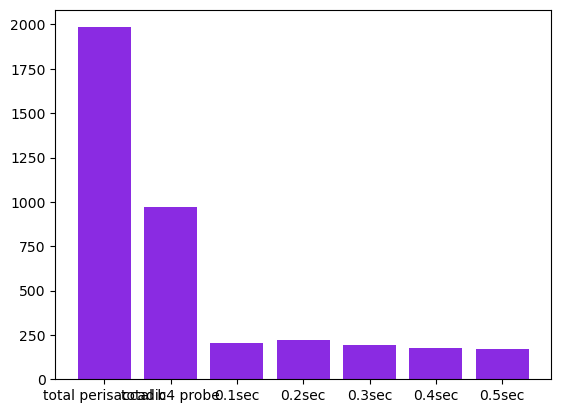

In [190]:
x = ['total perisaccadic', 'total b4 probe', '0.1sec', '0.2sec', '0.3sec', '0.4sec', '0.5sec']
y = [len(perisaccadicProbes[str(session.date)]), len(sacPreProbe), len(sac01), len(sac02), len(sac03), len(sac04), len(sac05)]
plt.bar(x, y, color='blueviolet')

In [186]:
session = sessionsMlati[6]
v = 0 
p = 0
agree = list()
unitsP = premotorUnitsZeta[str(session.date)]
unitsV = visualUnitsZeta[str(session.date)]
for u in unitsP:
    if u in unitsV:
        agree.append(u)
#visualArray = np.zeros((len(visualUnitsZeta[str(session.date)]) - len(agree), len(perisaccadicProbes[str(session.date)])))
#premotorArray = np.zeros((len(premotorUnitsZeta[str(session.date)]) - len(agree), len(perisaccadicProbes[str(session.date)])))
visualArray = np.zeros((len(visualUnitsZeta[str(session.date)]) - len(agree), len(sacPreProbe)))
premotorArray = np.zeros((len(premotorUnitsZeta[str(session.date)]) - len(agree), len(sacPreProbe)))
for unit in session.population:
    spikeTimes = unit.timestamps
    #for i, probe in enumerate(perisaccadicProbes[str(session.date)]):
    for i, probe in enumerate(sacPreProbe):
        if unit.cluster in agree:
            continue
        if unit.cluster in premotorUnitsZeta[str(session.date)]:
            #sacRel = session.saccadeTimestamps[:, 0] - probe
            #minSac = np.nanmin(abs(sacRel))
            #nearInd = np.where(abs(sacRel) == minSac)[0]
            #nearestSac = session.saccadeTimestamps[nearInd, 0]
           # start = nearestSac - 0.3
            #end = nearestSac
            start = probe - 0.1
            end = probe
            mask = np.logical_and(spikeTimes > start, spikeTimes < end)
            activity = len(spikeTimes[mask])/0.3
            premotorArray[p, i] = activity
        elif unit.cluster in visualUnitsZeta[str(session.date)]:
            start = probe
            end = probe + 0.25
            mask = np.logical_and(spikeTimes > start, spikeTimes < end)
            activity = len(spikeTimes[mask])/0.3
            visualArray[v, i] = activity

    if unit.cluster not in agree:
        if unit.cluster in visualUnitsZeta[str(session.date)]:
            v = v+1
        elif unit.cluster in premotorUnitsZeta[str(session.date)]:
            p = p+1

In [79]:
# plt.pcolor(visualArray)
# plt.colorbar()
%matplotlib qt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
plt.pcolor(scaler.fit_transform(premotorArray.T), vmin=-3, vmax=3)
plt.colorbar()

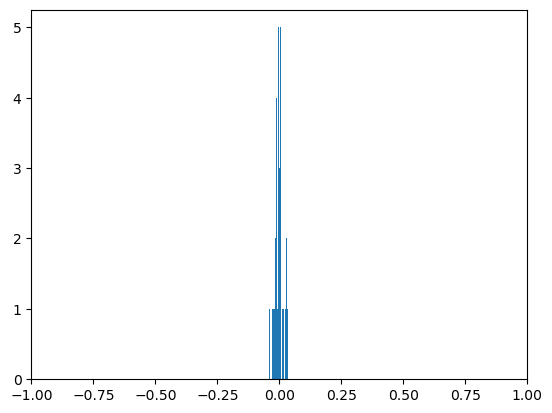

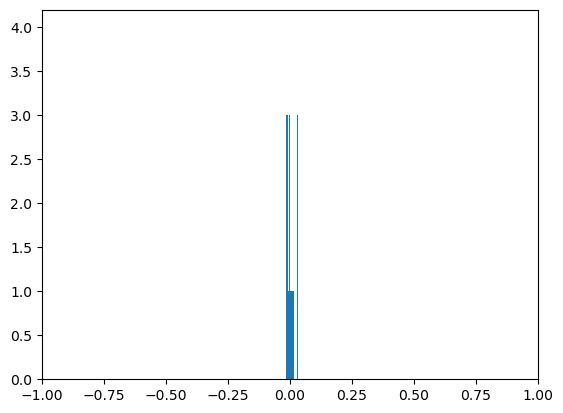

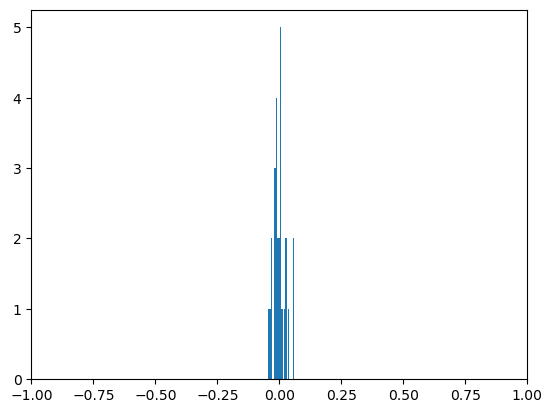

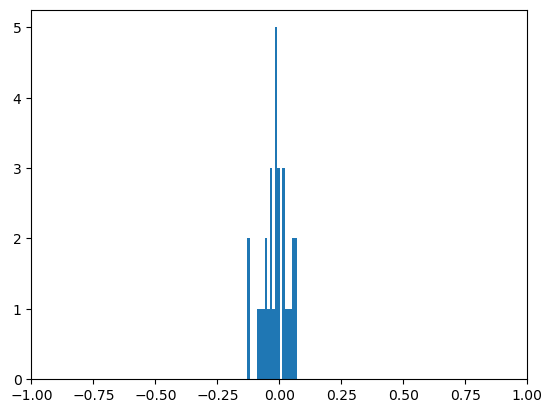

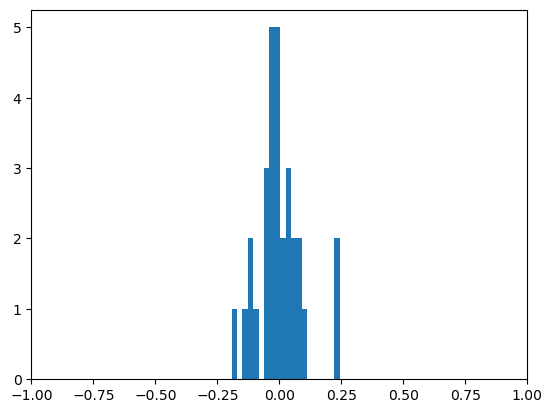

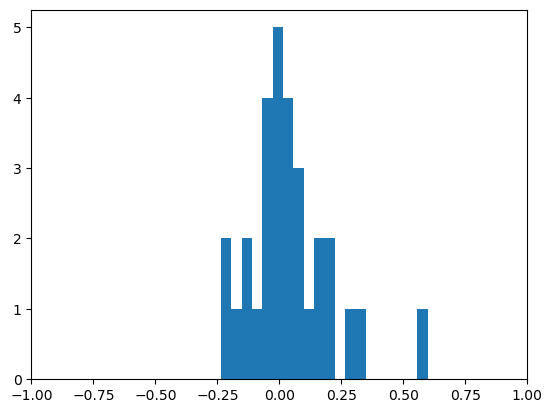

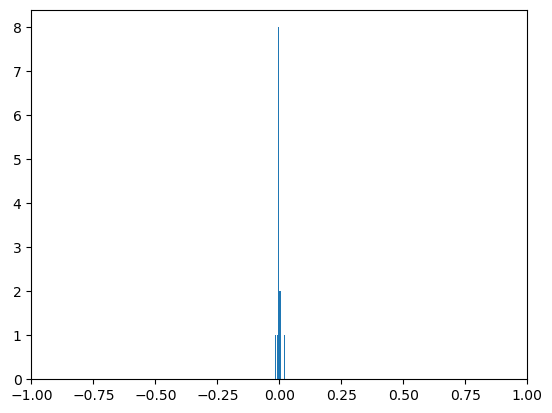

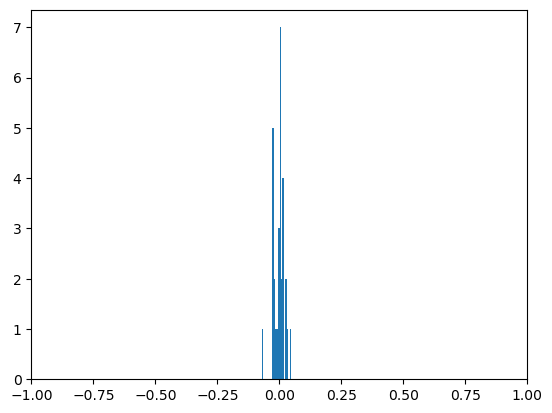

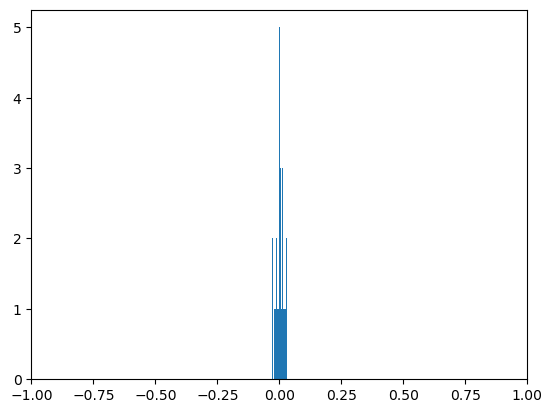

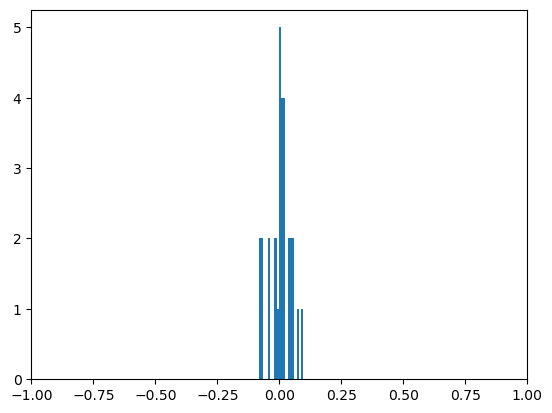

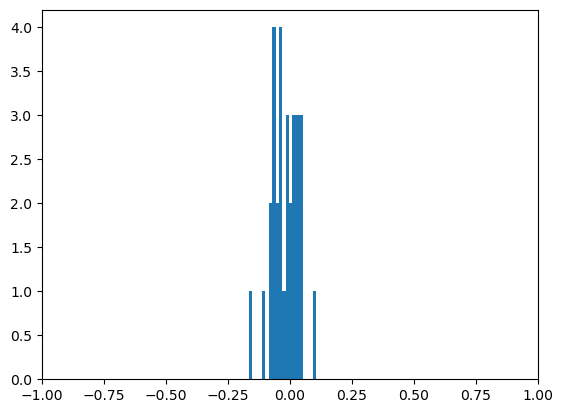

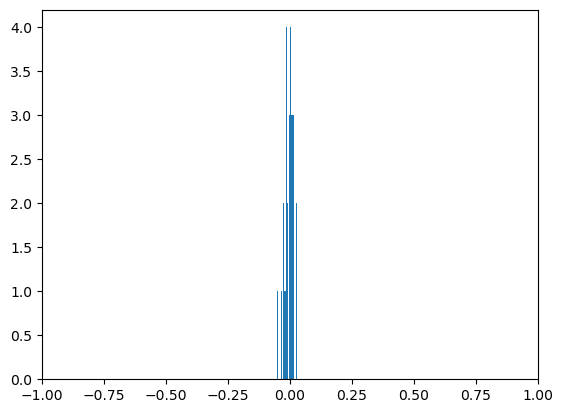

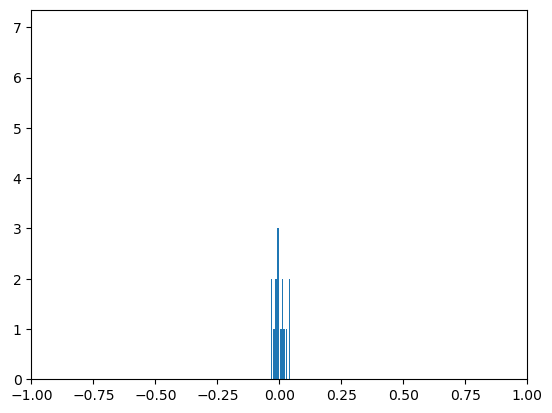

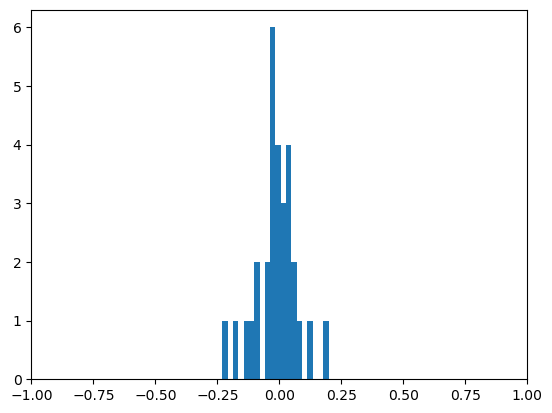

In [108]:
#visualArrayPredicted = np.zeros((len(perisaccadicProbes[str(session.date)]), len(visualUnitsZeta[str(session.date)]),))
weightsArray = np.zeros((len(premotorUnitsZeta[str(session.date)]) - len(agree), len(visualUnitsZeta[str(session.date)]) - len(agree)))
premotorZTmp = stats.zscore(premotorArray.T)
premotorZ = np.nan_to_num(premotorZTmp, nan=0)
visualZTmp = stats.zscore(visualArray)
visualZ = np.nan_to_num(visualZTmp, nan=0)
scoreList = list()
for i, unit in enumerate(visualZ):
    plt.figure(i)
    model = LinearRegression()
    model.fit(premotorZ, visualZ[i, :])
    predicted = model.predict(premotorZ)
    score = model.score(premotorZ, visualZ[i, :])
    scoreList.append(score)
    weights = model.coef_
    weightsArray[:, i] = weights
    plt.hist(weights, bins=20)
    plt.xlim(-1, 1)
    #visualArrayPredicted[:, i]  = predicted

In [140]:
print(premotorZ[1].shape)
print(len(visualZ[1]))

(30,)
14


In [187]:
#visualArrayPredicted = np.zeros((len(perisaccadicProbes[str(session.date)]), len(visualUnitsZeta[str(session.date)]),))
#SPLIT INTO SUP, ENH, UNMOD & LOOK AT CORRELATIONS WITHIN EACH GROUP
#THEN CALC AN AVG ACROSS ONE OF THE 2 AXES THEN WOULD HAVE 3 ARRAYS THAT WE CAN PLOT
weightsArray = np.zeros((len(premotorUnitsZeta[str(session.date)]) - len(agree), len(visualUnitsZeta[str(session.date)]) - len(agree)))
premotorZTmp = stats.zscore(premotorArray.T)
premotorZ = np.nan_to_num(premotorZTmp, nan=0) 
visualZTmp = stats.zscore(visualArray)
visualZ = np.nan_to_num(visualZTmp, nan=0).T
scoreList = list()
for i in range(len(premotorZ[1])):
    for j in range(len(visualZ[1])):
        model = LinearRegression()
        model.fit(premotorZ[:, i].reshape(-1, 1), visualZ[:, j])
        predicted = model.predict(premotorZ[:, i].reshape(-1, 1))
        score = model.score(premotorZ[:, i].reshape(-1, 1), visualZ[:, j])
        scoreList.append(score)
        weights = model.coef_
        weightsArray[i, j] = weights
        #visualArrayPredicted[:, i]  = predicted

/tmp/ipykernel_61470/2706584271.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weightsArray[i, j] = weights
/tmp/ipykernel_61470/2706584271.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weightsArray[i, j] = weights
/tmp/ipykernel_61470/2706584271.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weightsArray[i, j] = weights
/tmp/ipykernel_61470/2706584271.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and 

Text(0, 0.5, 'Visual Neurons')

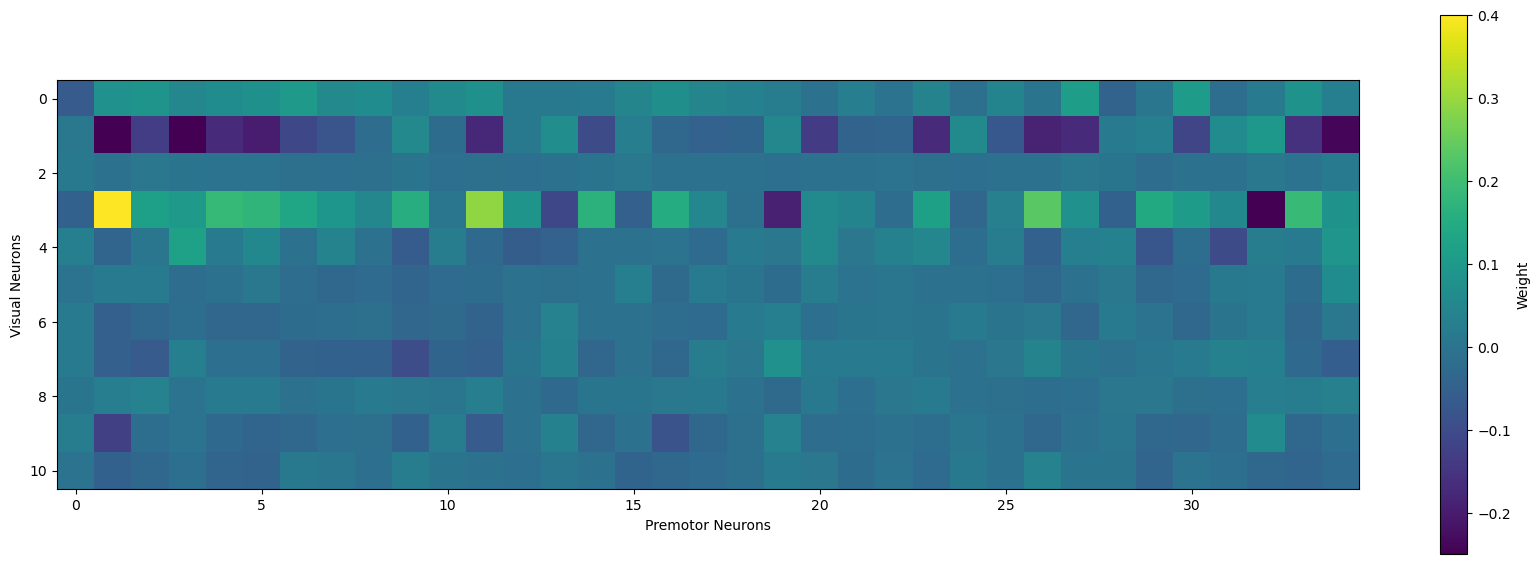

In [189]:
plt.figure(figsize = (21,7))
plt.imshow(weightsArray.T, vmin=-0.25, vmax=0.4)
plt.colorbar(label='Weight')
#plt.title('Linear Regression Weights Between Premotor and Visual Neurons')
plt.xlabel('Premotor Neurons')
plt.ylabel('Visual Neurons')

(array([ 1.,  0.,  0.,  1.,  2.,  5.,  4., 31.,  1.,  9.]),
 array([-3.72509041e-17, -3.22841169e-17, -2.73173297e-17, -2.23505425e-17,
        -1.73837553e-17, -1.24169680e-17, -7.45018082e-18, -2.48339361e-18,
         2.48339361e-18,  7.45018082e-18,  1.24169680e-17]),
 <BarContainer object of 10 artists>)

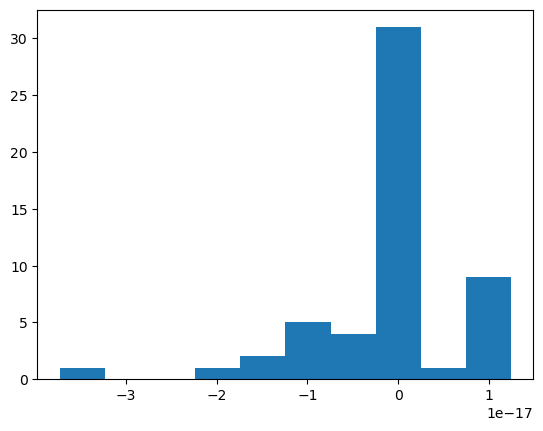

In [94]:
weightsArray.shape
PMmean = np.mean(weightsArray, axis=1)
plt.hist(PMmean)
#plt.xlim(-0.1, 0.1)

In [10]:
#premotorReshaped = np.zeros((len(perisaccadicProbes[str(session.date)]), ))
#premotorReshaped = premotorArray.reshape(len(perisaccadicProbes[str(session.date)]), len(premotorUnitsZeta[str(session.date)])*20)
#visualReshaped = visualArray[0, :, :].flatten()
#print(visualArray[0,:].shape)
window = (-0.2, 0.5)
%matplotlib inline

saccadeTimestamps = session.saccadeTimestamps[:, 0]
#saccadeTimestamps = np.array(sacLists[str(session.date)])
areaLabels = session.load('nptracer/labels')
transformed = session.load('nptracer/transformed')
#brainAreas = npt.translateBrainAreaIdentities(areaLabels)
spikeClustersFile = session.home.joinpath('ephys/sorting/manual/spike_clusters.npy')
uniqueSpikeClusters = np.unique(np.load(spikeClustersFile))
for unit in session.population[0:20]:
    index = np.where(uniqueSpikeClusters == unit.cluster)[0].item()
    if unit.cluster in visualUnitsZeta[str(session.date)]:
        L = list()
        #if index in premotorUnits[str(session.date)]:
            #fig, axs = plt.subplots()
        for probe in session.probeTimestamps:
            spikeTimestamps = unit.timestamps
            b1 = probe + window[0]
            b2 = probe + window[1]
            maskB = np.logical_and(spikeTimestamps >= b1, spikeTimestamps < b2)
            b = spikeTimestamps[maskB] - probe
            L.append(b)
        L1 = np.array(L)
        fig, ax = plt.subplots()
        font = {'size' : 15}
        plt.rc('font', **font)
        plt.gca().invert_yaxis()
        for rowIndex, row in enumerate(L1):
            x = row
            y0 = rowIndex - 0.5
            y1 = rowIndex + 0.5
            ax.vlines(x, y0, y1, color='k')
        ax.set_ylabel('Trial')
        ax.set_xlabel('Time from saccade (sec)')
        fig.set_figheight(10)
        fig.set_figwidth(6)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6780,) + inhomogeneous part.

In [223]:
model = pyglmnet.glm.Poisson()
model.fit(premotorArray.T, visualArray[i,:], Z)

ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

In [124]:
y_list = list()
w_list = list()
for i in range(15):
    w = np.random.uniform(-1,-0.5,30) 
    x = np.random.normal(20, 3, [30,10])
    y = np.dot(w, x)
    noise = np.random.uniform(-1, 1, 10)
    adjusted_y = y + noise
    y_list.append(adjusted_y)
    w_list.append(w)

In [49]:
w = np.random.uniform(-1,-0.5,50) 
x = np.random.normal(20, 3, [50,10])
y = np.dot(w, x)
noise = np.random.uniform(-0.01, 0.01, 10)

In [125]:
weightsArray = np.zeros((30, 15))
wArray = np.zeros((30, 15))
for i in range(15):
    model = LinearRegression()
    model.fit(x.T, y_list[i])
    predicted = model.predict(x.T)
    score = model.score(x.T, adjusted_y)
    weights = model.coef_
    weightsArray[:, i] = weights
    wArray[:, i] = w[i]

In [50]:
model = LinearRegression()
model.fit(x.T, y)
predicted = model.predict(x.T)
score = model.score(x.T, y)
weights = model.coef_

[-0.50149907 -0.6949257  -0.61654621 -0.79219141 -0.60592558 -0.51277949
 -0.53708298 -0.54390323 -0.976097   -0.71950706 -0.63789215 -0.97881921
 -0.80356662 -0.77549544 -0.82840998 -0.81464528 -0.57424588 -0.75422209
 -0.7058668  -0.97625029 -0.72190441 -0.60015023 -0.95915554 -0.89104562
 -0.96416564 -0.5734917  -0.5263039  -0.61959709 -0.67882732 -0.94411263]


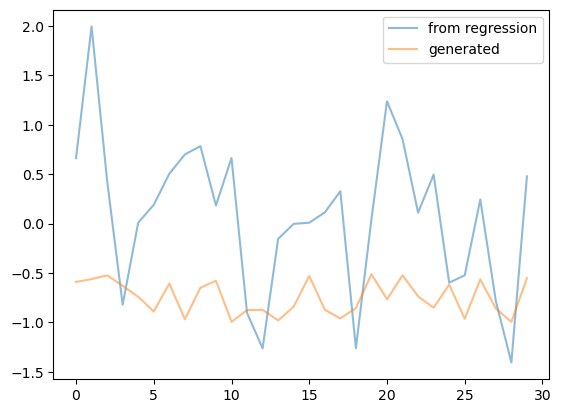

In [64]:
#print(weights)
print(w)
#print(score)
plt.plot(weightsArray[:, 1], label='from regression', alpha=0.5)
plt.plot(w_list[1], label='generated', alpha=0.5)
plt.legend()

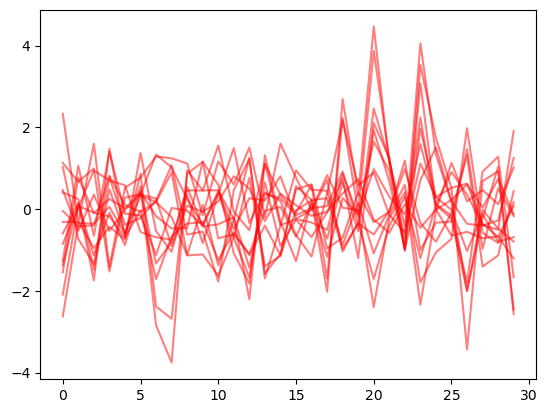

In [113]:
for i in range(len(visualUnitsZeta[str(session.date)]) - len(agree)):
    plt.plot(weightsArray[:, i], label='from regression', alpha=0.5, color='r')
    #plt.plot(w_list[i], label='generated', alpha=0.5, color='b')

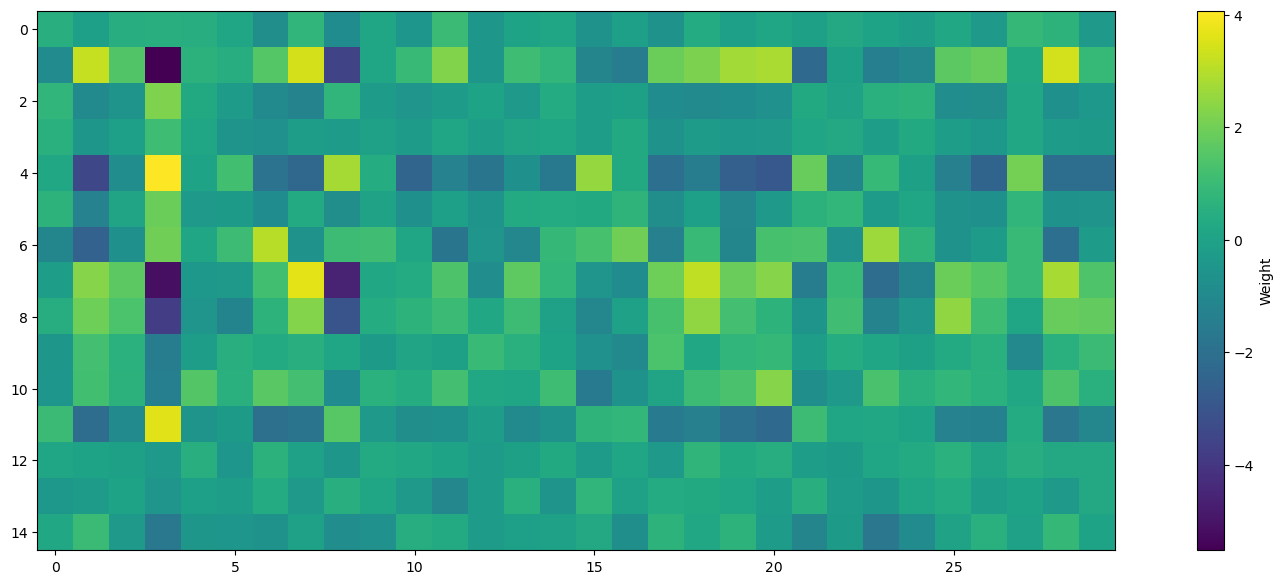

In [126]:
plt.figure(figsize = (21,7))
plt.imshow(weightsArray.T)
plt.colorbar(label='Weight')

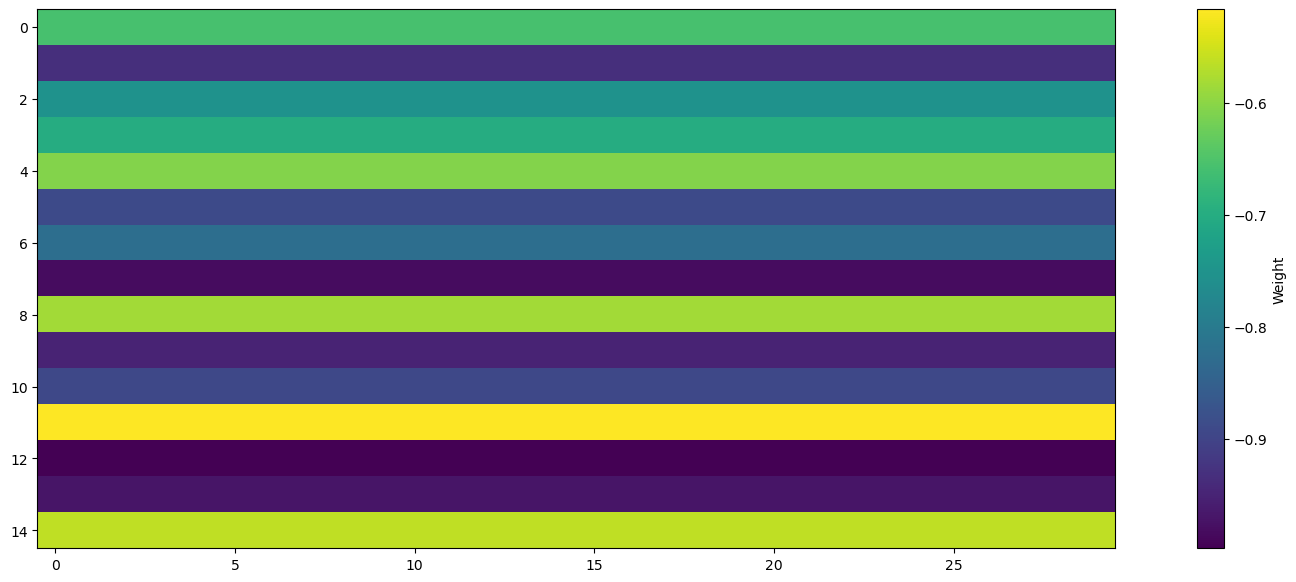

In [7]:
plt.figure(figsize = (21,7))
plt.imshow(wArray.T)
plt.colorbar(label='Weight')